# One dimensional approxiamtion for the two dimensional system
Here we solve the equations
$$
\partial_{t}P(x,t)=-\partial_{x}J(x,t),\quad J(x,t)=-[P(x,t)\partial V(x)+T(x,t)\partial_{x}P(x,t)]\\
\partial_{t}T(x,t)=-AJ\partial_{x}V(x)+B_{1}\partial_{xx}T(x,t)-B_{2}[T(x,t)-T_{0}]
$$
This corresponds to a one dimensional system where heat is dissipated into the environment at temperature $T_{0}$ through the term $-B_{2}[T(x,t)-T_{0}]$. We consider a situation where both the temperature and the density are periodic in the $x$ direction, therefore allowing us to solve the system by writing our equations as a Fourier series. For more details, see the thesis:
https://ourarchive.otago.ac.nz/handle/10523/8237

The code for the spectral discretization is in `BrownianDynamics/src/spectral.jl`.

In [1]:
using Plots
using OrdinaryDiffEq
using OffsetArrays
using LaTeXStrings
using FFTW
using LinearAlgebra
using BrownianDynamics

In [2]:
# This code initializes the spectral methods. `nn` is the
# number of spectral frequencies.
nn = 256  # Number of frequencies.
nd2 = round(Int,nn/2)
p = OffsetArray{Complex{Float64}}(undef,-round(Int,nn/2):round(Int,nn/2-1))
p[:] = zeros(Complex{Float64},nn)
p[-2:2] = [0.0 0.0 1.0 0.0 0.0]
vv = OffsetArray{Complex{Float64}}(undef,-round(Int,nn/2):round(Int,nn/2-1))
vv[:] = zeros(Complex{Float64},nn)
# vv[-2:2] = [0.25 0.0 1.0 0.0 0.25]
vv[-2:2] = 3*[0.0 0.5 0.0 0.5 0.0]
tt = OffsetArray{Complex{Float64}}(undef,-round(Int, nn/2):round(Int,nn/2-1))
tt[:] = zeros(Complex{Float64},nn)
tt[-1:1] = [0.0 1.0 0.0]

p = collect(p)
vv = collect(vv)
tt = collect(tt)
ϕ0 = [p;tt]

T = Complex{Float64}
nu = length(vv)
nv = length(vv)
n = nu+nv-1
np2 = n > 1024 ? nextprod([2,3,5],n) : nextpow(2,n)
upad = [vv;zeros(T,np2-nu)]
vpad = [vv;zeros(T,np2-nv)]


plan = plan_fft!(upad)
iplan = plan_ifft!(upad)
y = similar(upad)

L = 50
l = 1
A = 1/(2L*l)/0.5
B = [(2/3)*(l)/L^2 2L*(1/l)]
force = -1
T0 = 1.0

1.0

In [3]:
params = SpectralParameters{Float64}(plan,iplan,A,B |> vec,force,vv,T0);

In [4]:
tspan = (0.0,1.0)

prob = ODEProblem(spectral_rhs!,ϕ0,tspan,params)

┌ Warning: The overloading form for Jacobians is deprecated. Use the DiffEqFunction
└ @ DiffEqBase /home/jackd/.julia/packages/DiffEqBase/EFqMn/src/diffeqfunction.jl:584


ODEProblem with uType Array{Complex{Float64},1} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: Complex{Float64}[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]

# Find the steady state

In [5]:
integrator = init(prob,TRBDF2(autodiff=false))
@time steady_state = solve_steady_state(integrator,params,maxiters=25,steadytol=1e-14)
@show norm([spectral_rhs!(copy(ϕ0),ϕ0,params,0);ϕ0[nd2+1]-1])/nn
norm([spectral_rhs!(copy(ϕ0),steady_state,params,0);steady_state[nd2+1]-1])/nn

  5.675657 seconds (14.22 M allocations: 861.364 MiB, 7.58% gc time)
norm([spectral_rhs!(copy(ϕ0), ϕ0, params, 0); ϕ0[nd2 + 1] - 1]) / nn = 0.32758553236652355


2.11900735843548e-16

maximum(steady_current) - minimum(steady_current) = 1.3233858453531866e-13


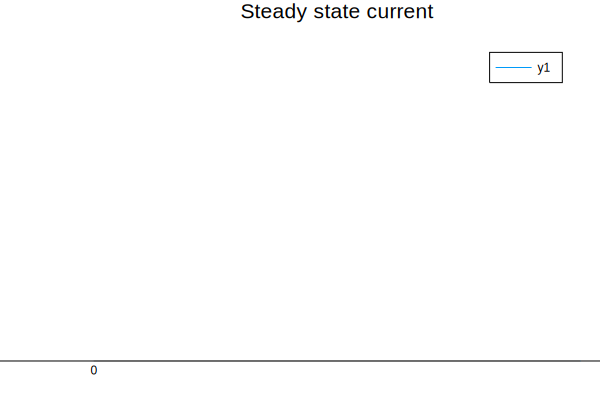

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW


In [6]:
steady_current = real_current(steady_state,params) .|> real
@show maximum(steady_current)-minimum(steady_current)
plot(steady_current)
title!("Steady state current")

The above plot shows that the steady state current is almost completely constant.

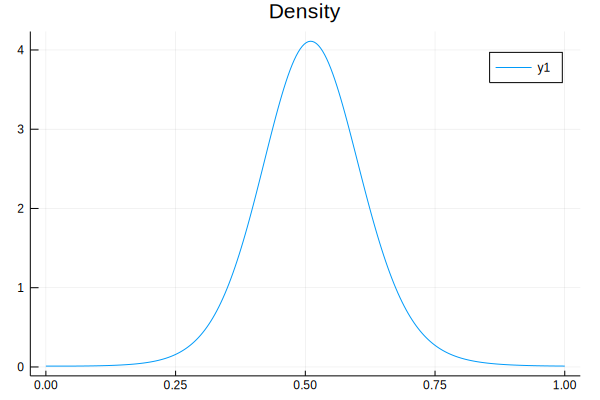

In [7]:
xx = range(0,stop=1,length=nn)

plot(xx,fft(fftshift(steady_state[1:nn])) .|> real)
title!("Density")

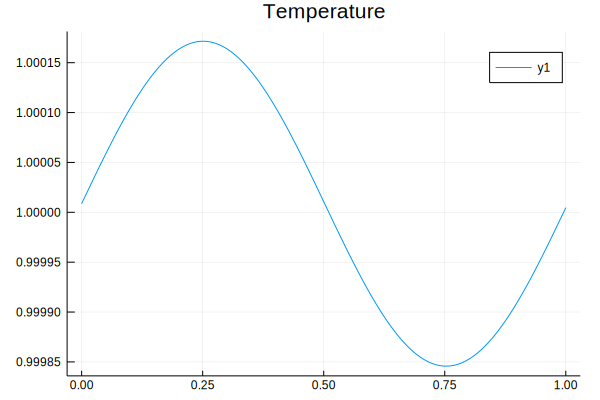

In [8]:
# Plot the temperature.
plot(xx,fft(fftshift(steady_state[nn+1:end])) .|> real)
title!("Temperature")

# Solve with respect to time

In [9]:
@time sol = solve(prob,TRBDF2(autodiff=false),abstol=1e-10,reltol=1e-10);

 65.572471 seconds (9.71 M allocations: 2.377 GiB, 1.45% gc time)


## Show how much the system is changing with respect to time
In the steady state, the right hand side of the ODE is precisely zero. Here, we show the magnitude of the right hand side with respect to time.

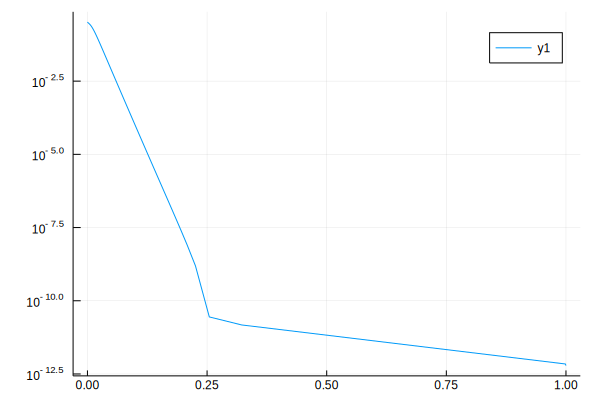

In [10]:
plot(sol.t,[norm(spectral_rhs!(copy(ϕ0),sol(t),params,0))/(nn) for t in sol.t],yscale=:log10)

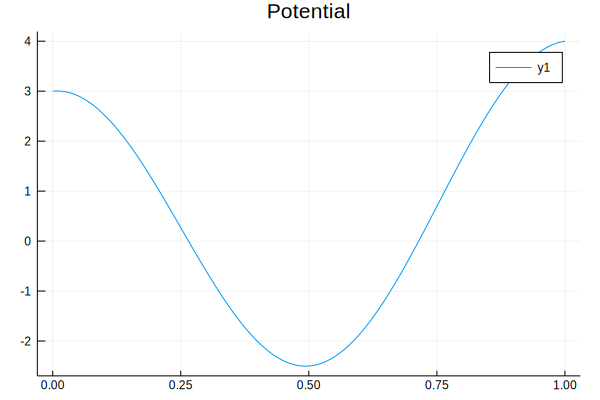

In [11]:
plot(xx,fft(fftshift(vv))-force*xx .|> real)
title!("Potential")

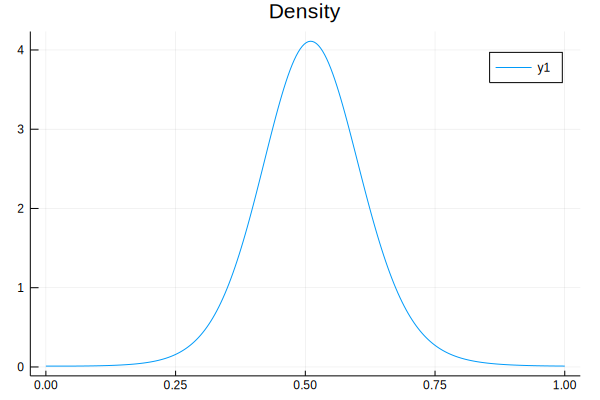

In [12]:
plot(xx,fft(fftshift(sol[end][1:nn])) .|> real)
title!("Density")

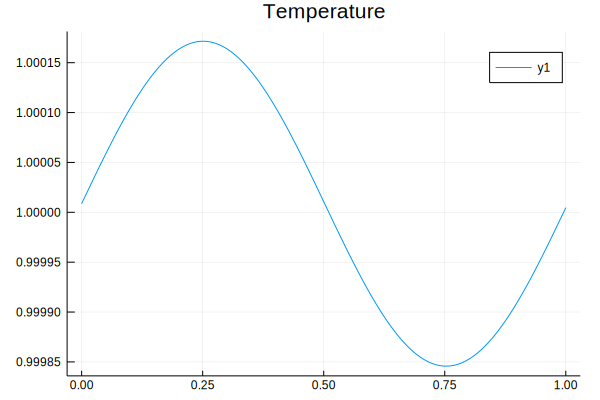

In [13]:
plot(xx,fft(fftshift(sol[end][nn+1:end])) .|> real)
title!("Temperature")

# Boltzmann distribution

In [14]:
params = SpectralParameters{Float64}(plan,iplan,A,B |> vec,0,vv,T0)
V = fft(fftshift(vv))
# Calculate the Boltmann distribution in real space.
# When the force is zero, the steady state temperature is equal to T0.
boltz = exp.(-V/params.T0)
p_boltz = ifftshift(ifft(boltz))
# Normalization.
nd2 = round(Int,nn/2)
p_boltz /= p_boltz[nd2+1]
# Steady state temperature.
tt_equilibrium = fill(0.0+0.0im,nn)
tt_equilibrium[nd2+1] = T0

ϕ_equilibrium = [p_boltz;tt_equilibrium]
equilibrium_params = SpectralParameters{Float64}(plan,iplan,A,B |> vec,0,vv,T0)
norm(spectral_rhs!(copy(ϕ0),ϕ_equilibrium,equilibrium_params,0))  # Check that we are in the steady state.

2.05065303563696e-10

In [15]:
# Check that the current is zero in the steady state.
real_current(ϕ_equilibrium,equilibrium_params) |> norm

4.941496659586239e-12

# Multiple parameters
Calculate the steady state for multiple parameters.

This is where we set `A` and `B`. The above cells simply initialized the spectral code with arbitrary values of `A` and `B`.

In [16]:
nforces = 30
nAs = 3
l = 0.05
L = 1
barriersize = 3
forcevec = range(0,stop=30,length=nforces)
# We keep B constant while we consider three different values of A. The values of A are stored in Avec.
Avec = [0.2 20 200] # K=0.05*[0.2 20 200] =0.01 1 10
B = [1 2/(l^2)]
# Preallocate arrays to store data into.
Jxsum = Array{Float64}(undef,nforces,nAs)
errorvec = Array{Float64}(undef,nforces,nAs)
solutions = Array{Complex{Float64}}(undef,2nn,nforces,nAs)
vv = OffsetArray{Complex{Float64}}(undef,-round(Int,nn/2):round(Int,nn/2-1))
vv *= 0.0 
vv[-2:2] = barriersize*[0.0 0.5 0.0 0.5 0.0]
vv = collect(vv)
# When the force is zero, we will have the equilibrium steady state.
params = SpectralParameters{Float64}(plan,iplan,A,B |> vec,forcevec[1],vv,T0)
global prob = remake(prob,p=params,u0=copy(ϕ_equilibrium))
integrator = init(prob,TRBDF2(autodiff=false),abstol=1e-6,reltol=1e-6)
@time steady_state = evolve_to_steady_state!(integrator,params,steadytol=1e-5,
                                             maxiters=10)

@time for (i,force) in enumerate(forcevec)
    for (j,A) in enumerate(Avec)
        # Redefine the problem for the current value of the force.
        params = SpectralParameters{Float64}(plan,iplan,A,B |> vec,force,vv,T0)
        global prob = remake(prob,p=params,u0=steady_state)
        integrator = init(prob,TRBDF2(autodiff=false))
        # Find the steady state.
        steady_state[:] .= solve_steady_state(integrator,params,steadytol=1e-12,maxiters=8)
        # Store results.
        solutions[:,i,j] .= steady_state
        Jxsum[i,j] = real_current(steady_state,params) |> sum |> real
        errorvec[i,j] = norm([spectral_rhs!(copy(ϕ0),steady_state,params,0);steady_state[nd2+1]-1])/nn
    end
    # Reset the steady state to the one with the lowest value of A.
    steady_state[:] .= solutions[:,i,1]
end
# prob = remake(prob,p=params,u0=steady_state)

  0.021239 seconds (39.89 k allocations: 2.741 MiB)
164.142001 seconds (1.78 M allocations: 20.769 GiB, 2.83% gc time)


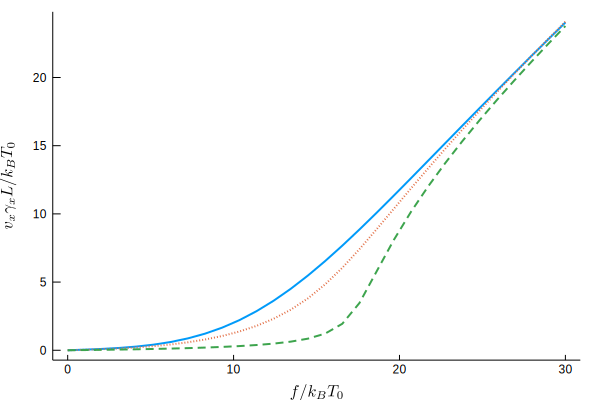

In [17]:
plot(forcevec,-Jxsum[:,1]/nn,leg=false,grid=false,w=2)
plot!(forcevec,-Jxsum[:,2]/nn,linestyle=:dot,w=2)
plot!(forcevec,-Jxsum[:,3]/nn,linestyle=:dash,w=2)
xaxis!(L"f/k_{B}T_{0}")
yaxis!(L"v_{x}\gamma_{x}L/k_{B}T_{0}")

The behavior shown in the above figure is phenomenologically similar to the behavior shown in figure 1 of our paper.